### 2.1 Chuẩn bị dữ liệu

In [73]:
# Import các thư viện cần thiết
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
import seaborn as sns
import matplotlib.pyplot as plt

# 1. Tải dữ liệu từ URL
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-white.csv"
data = pd.read_csv(url, delimiter=';')

# 2. Tiền xử lý dữ liệu
# Thêm cột "Quality_Category" để nhóm chất lượng
# 0-4: Chất lượng thấp, 5-6: Tiêu chuẩn, 7-10: Chất lượng cao
data['Quality_Category'] = pd.cut(
    data['quality'],
    bins=[-1, 4, 6, 10],
    labels=['Low', 'Standard', 'High']
)

# Loại bỏ cột "quality" (không cần thiết)
data = data.drop(columns=['quality'])


In [74]:
# Kiểm tra thông tin dữ liệu
print(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4898 entries, 0 to 4897
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype   
---  ------                --------------  -----   
 0   fixed acidity         4898 non-null   float64 
 1   volatile acidity      4898 non-null   float64 
 2   citric acid           4898 non-null   float64 
 3   residual sugar        4898 non-null   float64 
 4   chlorides             4898 non-null   float64 
 5   free sulfur dioxide   4898 non-null   float64 
 6   total sulfur dioxide  4898 non-null   float64 
 7   density               4898 non-null   float64 
 8   pH                    4898 non-null   float64 
 9   sulphates             4898 non-null   float64 
 10  alcohol               4898 non-null   float64 
 11  Quality_Category      4898 non-null   category
dtypes: category(1), float64(11)
memory usage: 426.0 KB
None


In [75]:
# Kiểm tra sơ bộ
print(data.head())

   fixed acidity  volatile acidity  citric acid  residual sugar  chlorides  \
0            7.0              0.27         0.36            20.7      0.045   
1            6.3              0.30         0.34             1.6      0.049   
2            8.1              0.28         0.40             6.9      0.050   
3            7.2              0.23         0.32             8.5      0.058   
4            7.2              0.23         0.32             8.5      0.058   

   free sulfur dioxide  total sulfur dioxide  density    pH  sulphates  \
0                 45.0                 170.0   1.0010  3.00       0.45   
1                 14.0                 132.0   0.9940  3.30       0.49   
2                 30.0                  97.0   0.9951  3.26       0.44   
3                 47.0                 186.0   0.9956  3.19       0.40   
4                 47.0                 186.0   0.9956  3.19       0.40   

   alcohol Quality_Category  
0      8.8         Standard  
1      9.5         Standar

In [76]:
# Kiểm tra giá trị duy nhất trong nhãn:
print(data['Quality_Category'].value_counts())

Quality_Category
Standard    3655
High        1060
Low          183
Name: count, dtype: int64


In [77]:
# Kiểm tra thống kê dữ liệu:
print(data.describe())

       fixed acidity  volatile acidity  citric acid  residual sugar  \
count    4898.000000       4898.000000  4898.000000     4898.000000   
mean        6.854788          0.278241     0.334192        6.391415   
std         0.843868          0.100795     0.121020        5.072058   
min         3.800000          0.080000     0.000000        0.600000   
25%         6.300000          0.210000     0.270000        1.700000   
50%         6.800000          0.260000     0.320000        5.200000   
75%         7.300000          0.320000     0.390000        9.900000   
max        14.200000          1.100000     1.660000       65.800000   

         chlorides  free sulfur dioxide  total sulfur dioxide      density  \
count  4898.000000          4898.000000           4898.000000  4898.000000   
mean      0.045772            35.308085            138.360657     0.994027   
std       0.021848            17.007137             42.498065     0.002991   
min       0.009000             2.000000         

In [78]:
# 3. Xáo trộn dữ liệu
data = shuffle(data, random_state=None)

# 4. Xác định đặc trưng và nhãn
X = data.drop(columns=['Quality_Category'])
y = data['Quality_Category']

# 5. Phân chia tập dữ liệu theo tỷ lệ
splits = {'40/60': 0.4, '60/40': 0.6, '80/20': 0.8, '90/10': 0.9}
datasets = {}

for split_name, train_ratio in splits.items():
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, train_size=train_ratio, stratify=y, random_state=42
    )
    datasets[split_name] = {
        'feature_train': X_train,
        'label_train': y_train,
        'feature_test': X_test,
        'label_test': y_test,
    }


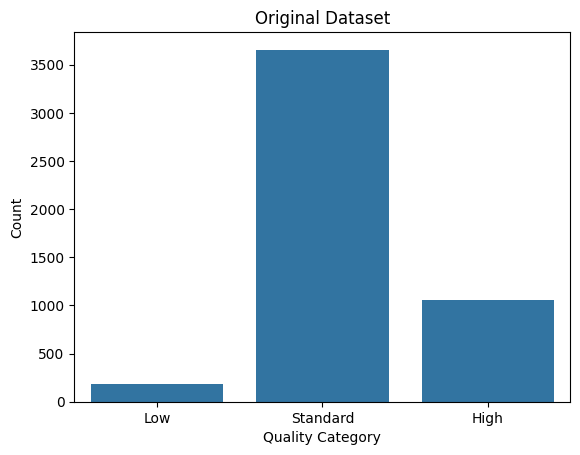

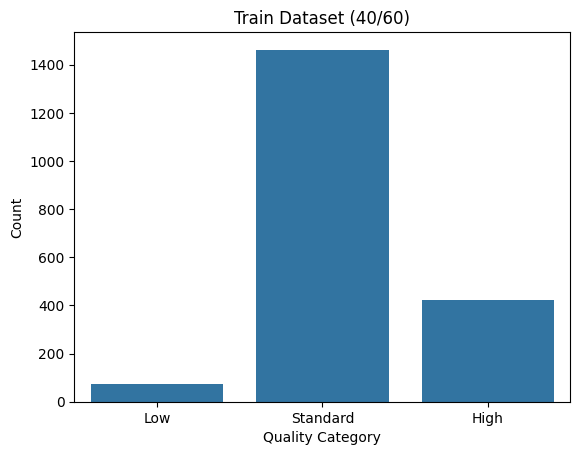

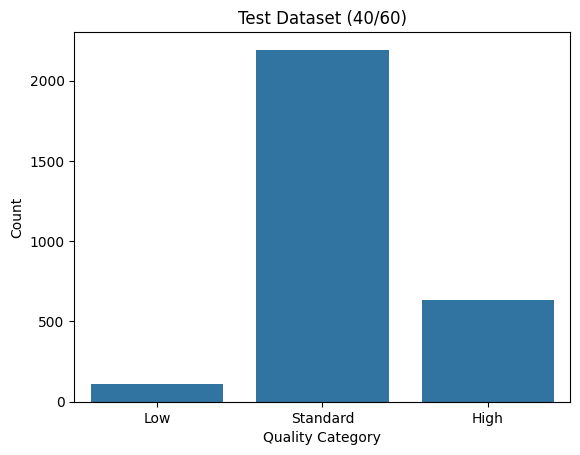

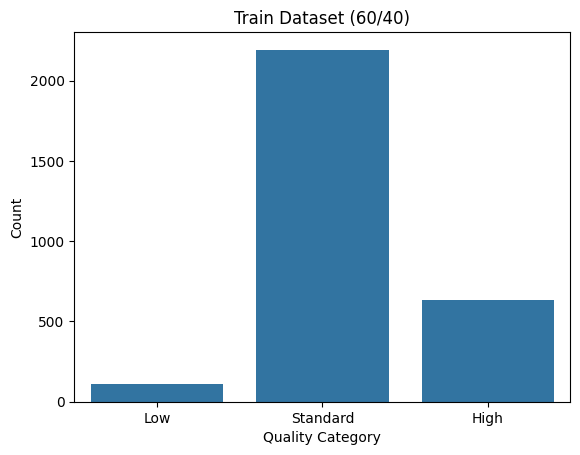

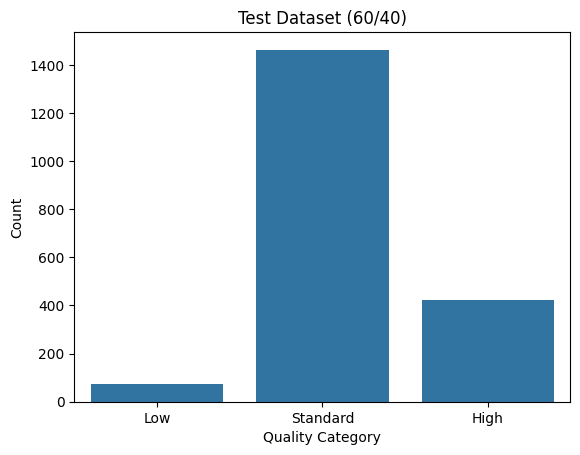

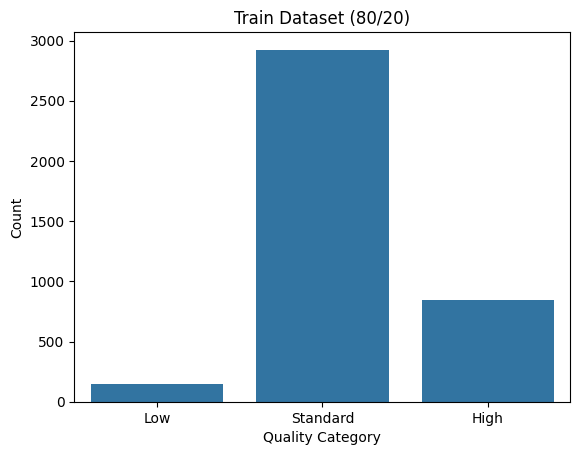

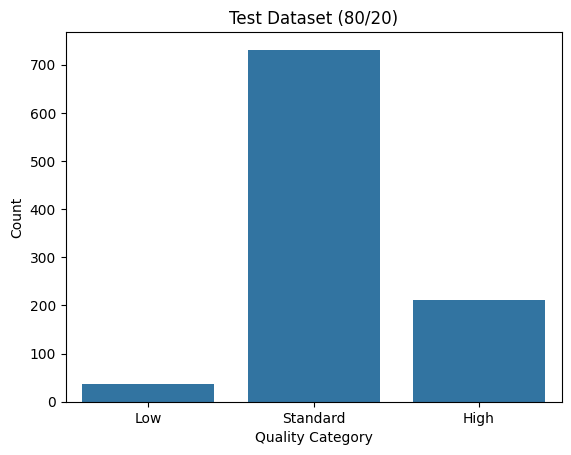

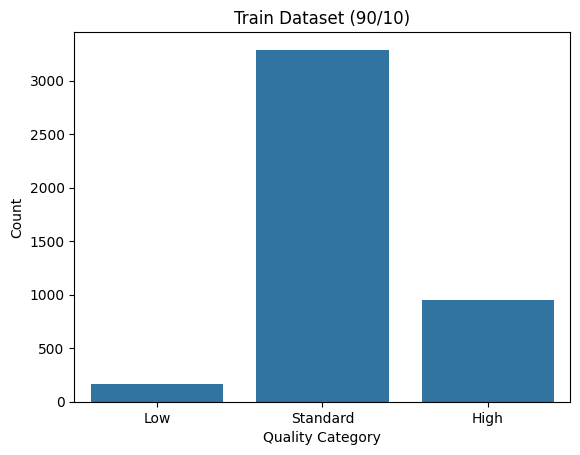

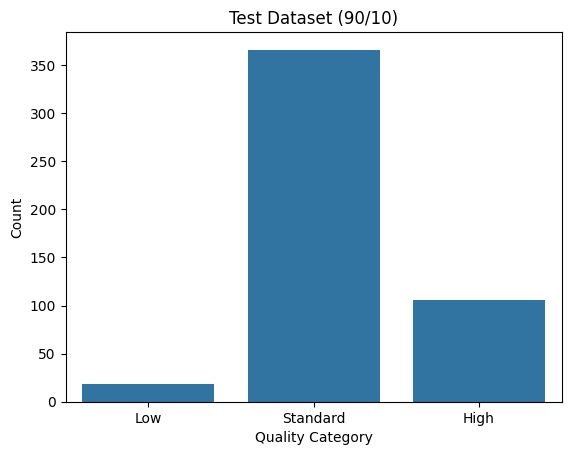

In [79]:
# 6. Hình dung phân phối nhãn
def plot_label_distribution(y, title):
    sns.countplot(x=y)
    plt.title(title)
    plt.xlabel('Quality Category')
    plt.ylabel('Count')
    plt.show()

# Phân phối dữ liệu gốc
plot_label_distribution(y, 'Original Dataset')

# Phân phối các tập con
for split_name, dataset in datasets.items():
    plot_label_distribution(dataset['label_train'], f'Train Dataset ({split_name})')
    plot_label_distribution(dataset['label_test'], f'Test Dataset ({split_name})')

### 2.2 Xây dựng bộ phân loại

In [80]:
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.metrics import classification_report, accuracy_score
import graphviz

In [81]:
# 1 Huấn luyện và trực quan hóa cây quyết định
def train_and_visualize(features_train, labels_train, features_test, labels_test, split_name):
    # Huấn luyện cây quyết định
    model = DecisionTreeClassifier(criterion='entropy', random_state=42)
    model.fit(features_train, labels_train)
    
    # Dự đoán trên tập kiểm tra
    predictions = model.predict(features_test)

    # Đánh giá hiệu suất mô hình
    print(f"--- Results for split {split_name} ---")
    print("Classification Report:")
    print(classification_report(labels_test, predictions))
    accuracy = accuracy_score(labels_test, predictions)
    print(f"Accuracy: {accuracy:.2f}\n")

    # Trực quan hóa cây quyết định
    print(f"--- Decision Tree for {split_name} ---")
    dot_data = export_graphviz(
        model,
        out_file=None,
        feature_names=features_train.columns,
        class_names=['Low','Standard','High'],
        filled=True,
        rounded=True,
        special_characters=True
    )
    graph = graphviz.Source(dot_data)
    graph.render(f"output1/{split_name.replace('/', '_')}")  # Lưu cây dưới dạng file PDF
    # display(graph)  # Hiển thị cây (hoặc sử dụng graph.render() để lưu file)


In [82]:
# 2. Huấn luyện và trực quan hóa với từng tập con
for split_name, dataset in datasets.items():
    train_and_visualize(
        features_train=dataset['feature_train'],
        labels_train=dataset['label_train'],
        features_test=dataset['feature_test'],
        labels_test=dataset['label_test'],
        split_name=split_name
    )

--- Results for split 40/60 ---
Classification Report:
              precision    recall  f1-score   support

        High       0.50      0.55      0.52       636
         Low       0.26      0.25      0.25       110
    Standard       0.83      0.81      0.82      2193

    accuracy                           0.73      2939
   macro avg       0.53      0.53      0.53      2939
weighted avg       0.74      0.73      0.74      2939

Accuracy: 0.73

--- Decision Tree for 40/60 ---
--- Results for split 60/40 ---
Classification Report:
              precision    recall  f1-score   support

        High       0.56      0.55      0.56       424
         Low       0.32      0.29      0.30        73
    Standard       0.84      0.85      0.85      1463

    accuracy                           0.77      1960
   macro avg       0.57      0.56      0.57      1960
weighted avg       0.76      0.77      0.76      1960

Accuracy: 0.77

--- Decision Tree for 60/40 ---
--- Results for split 80/20 ---


### 2.3 Đánh giá các bộ phân loại

In [83]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

In [84]:
def evaluate_model(features_test, labels_test, model, split_name):
    # Dự đoán trên tập kiểm tra
    predictions = model.predict(features_test)
    
    # Classification Report
    print(f"--- Classification Report for split {split_name} ---")
    print(classification_report(labels_test, predictions))
    
    # Confusion Matrix
    cm = confusion_matrix(labels_test, predictions)
    print(f"Confusion Matrix for split {split_name}:\n{cm}")
    
    # Trực quan hóa ma trận nhầm lẫn
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Reds', xticklabels=['Low','Standard', 'High'], yticklabels=['Low','Standard', 'High'])
    plt.title(f"Confusion Matrix for {split_name}")
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

    # Trả về mô hình và độ chính xác
    accuracy = accuracy_score(labels_test, predictions)
    return accuracy

--- Classification Report for split 40/60 ---
              precision    recall  f1-score   support

        High       0.50      0.55      0.52       636
         Low       0.26      0.25      0.25       110
    Standard       0.83      0.81      0.82      2193

    accuracy                           0.73      2939
   macro avg       0.53      0.53      0.53      2939
weighted avg       0.74      0.73      0.74      2939

Confusion Matrix for split 40/60:
[[ 349    4  283]
 [  10   27   73]
 [ 342   74 1777]]


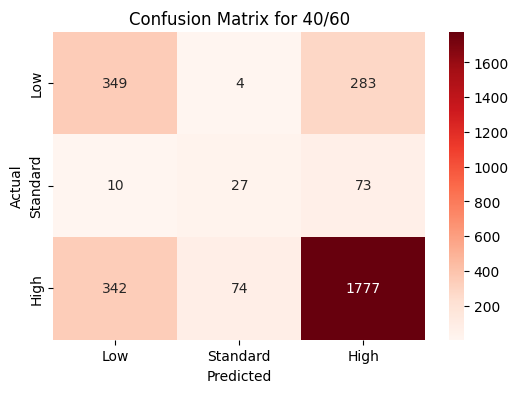

--- Classification Report for split 60/40 ---
              precision    recall  f1-score   support

        High       0.56      0.55      0.56       424
         Low       0.32      0.29      0.30        73
    Standard       0.84      0.85      0.85      1463

    accuracy                           0.77      1960
   macro avg       0.57      0.56      0.57      1960
weighted avg       0.76      0.77      0.76      1960

Confusion Matrix for split 60/40:
[[ 235    5  184]
 [   5   21   47]
 [ 179   40 1244]]


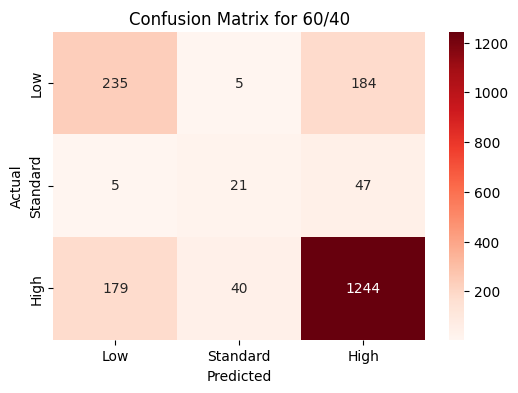

--- Classification Report for split 80/20 ---
              precision    recall  f1-score   support

        High       0.59      0.61      0.60       212
         Low       0.38      0.27      0.32        37
    Standard       0.86      0.86      0.86       731

    accuracy                           0.78       980
   macro avg       0.61      0.58      0.59       980
weighted avg       0.78      0.78      0.78       980

Confusion Matrix for split 80/20:
[[129   2  81]
 [  2  10  25]
 [ 89  14 628]]


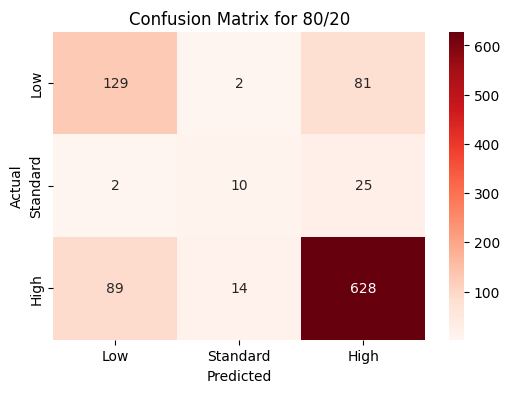

--- Classification Report for split 90/10 ---
              precision    recall  f1-score   support

        High       0.65      0.58      0.62       106
         Low       0.14      0.17      0.15        18
    Standard       0.84      0.86      0.85       366

    accuracy                           0.78       490
   macro avg       0.54      0.54      0.54       490
weighted avg       0.78      0.78      0.78       490

Confusion Matrix for split 90/10:
[[ 62   1  43]
 [  0   3  15]
 [ 33  18 315]]


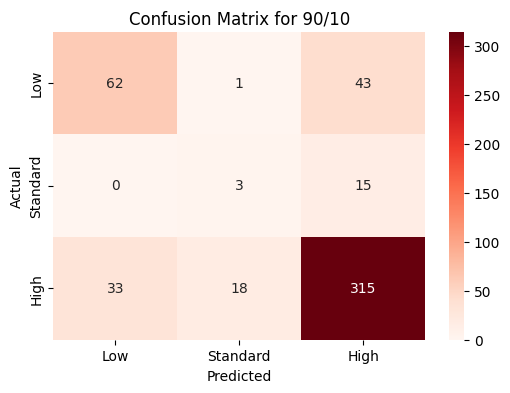

In [85]:
# 2. Lặp qua từng tập con để huấn luyện, đánh giá, và lưu kết quả
results = {}
for split_name, dataset in datasets.items():
    # Huấn luyện mô hình
    model = DecisionTreeClassifier(criterion='entropy', random_state=42)
    model.fit(dataset['feature_train'], dataset['label_train'])
    
    # Đánh giá mô hình
    accuracy = evaluate_model(
        features_test=dataset['feature_test'],
        labels_test=dataset['label_test'],
        model=model,
        split_name=split_name
    )
    
    # Lưu kết quả
    results[split_name] = accuracy

In [86]:
# 3. Hiển thị tổng hợp kết quả độ chính xác
print("--- Summary of Accuracy for Each Split ---")
for split_name, accuracy in results.items():
    print(f"Accuracy for {split_name}: {accuracy:.6f}")


--- Summary of Accuracy for Each Split ---
Accuracy for 40/60: 0.732562
Accuracy for 60/40: 0.765306
Accuracy for 80/20: 0.782653
Accuracy for 90/10: 0.775510


### 2.4 Độ sâu và độ chính xác

In [87]:
# 1. Lấy bộ dữ liệu huấn luyện và kiểm tra 80/20
X_train = datasets['80/20']['feature_train']
y_train = datasets['80/20']['label_train']
X_test = datasets['80/20']['feature_test']
y_test = datasets['80/20']['label_test']

--- Decision Tree with max_depth=None ---


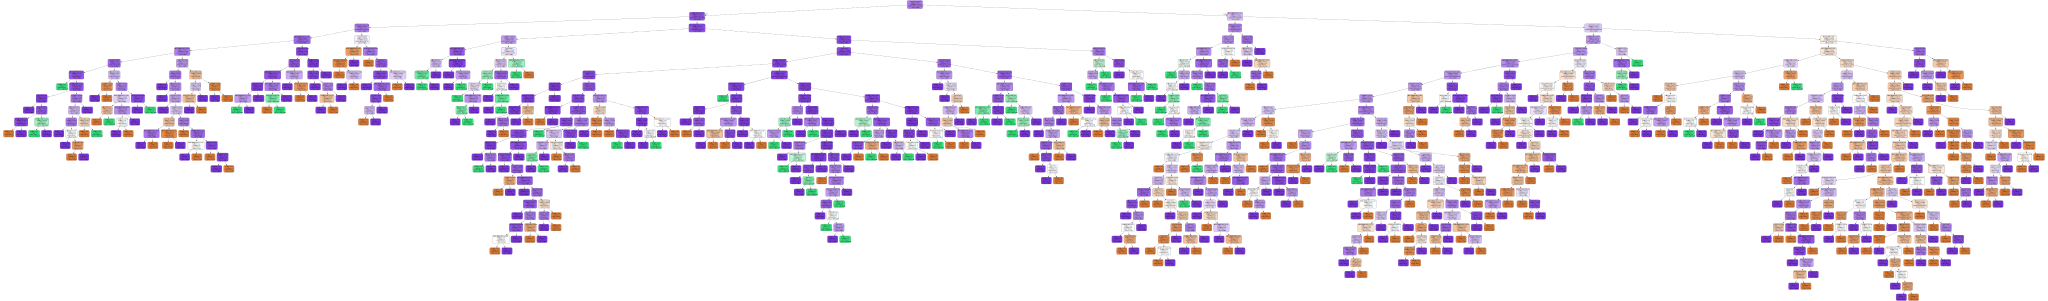

--- Decision Tree with max_depth=2 ---


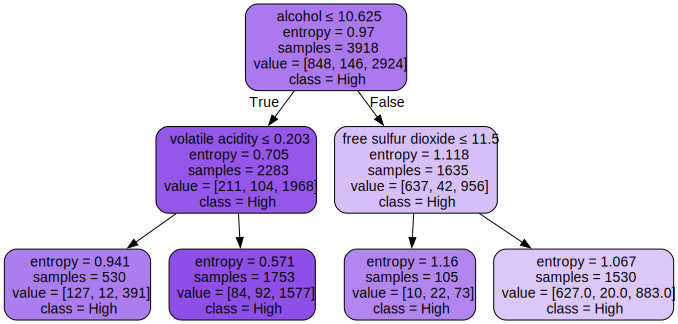

--- Decision Tree with max_depth=3 ---


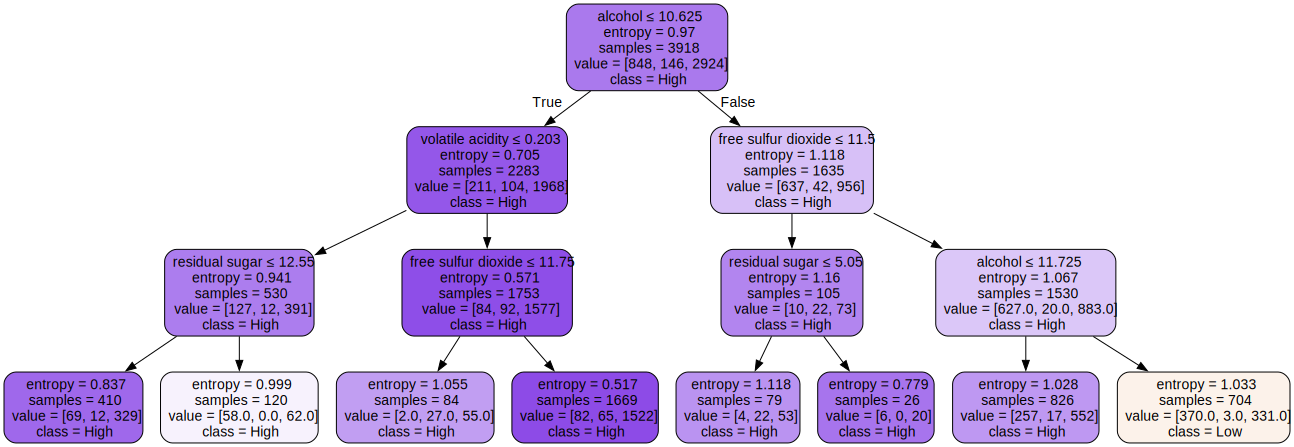

--- Decision Tree with max_depth=4 ---


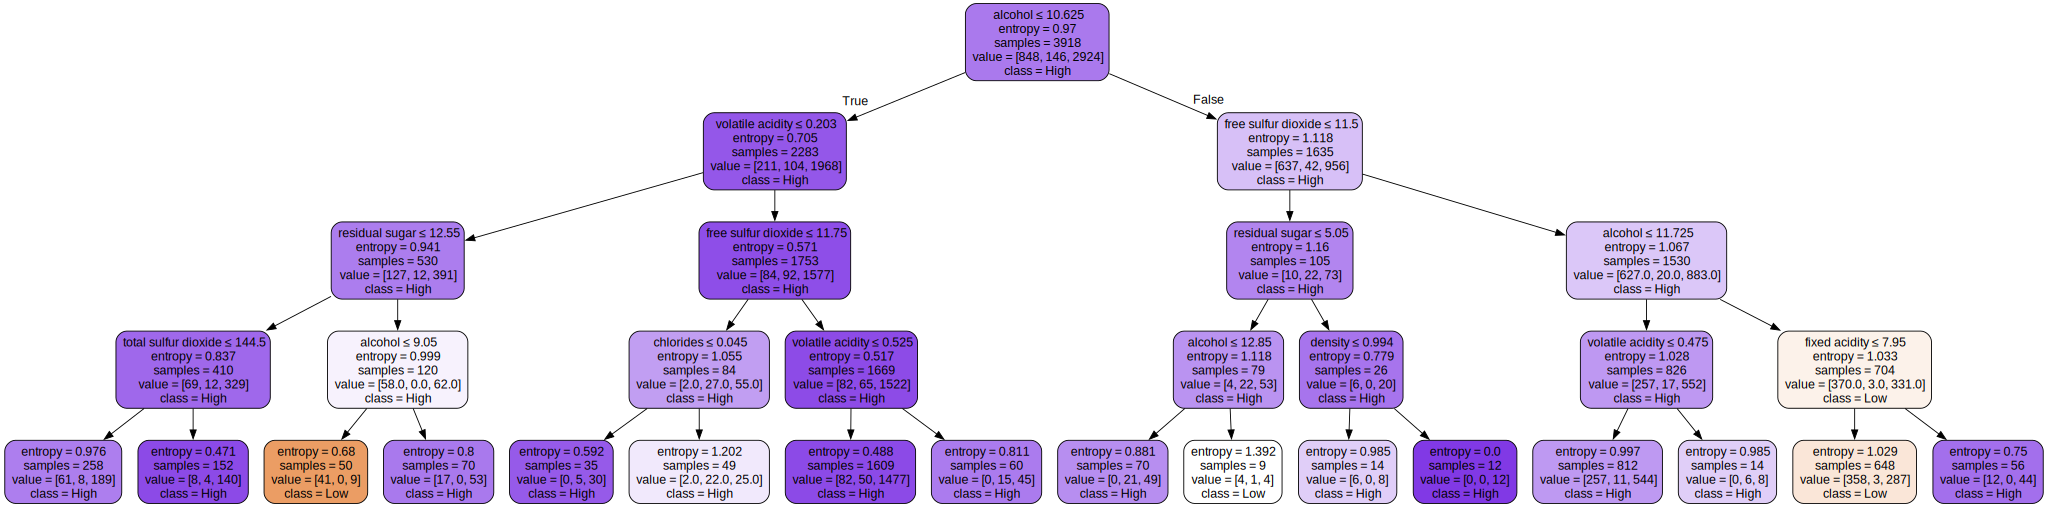

--- Decision Tree with max_depth=5 ---


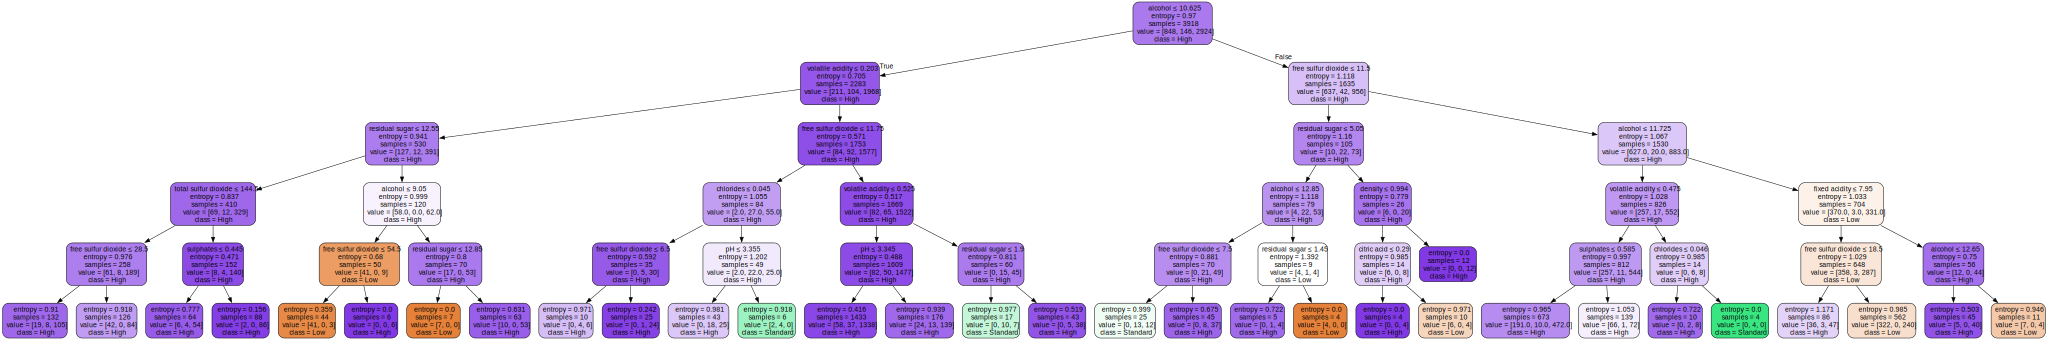

--- Decision Tree with max_depth=6 ---


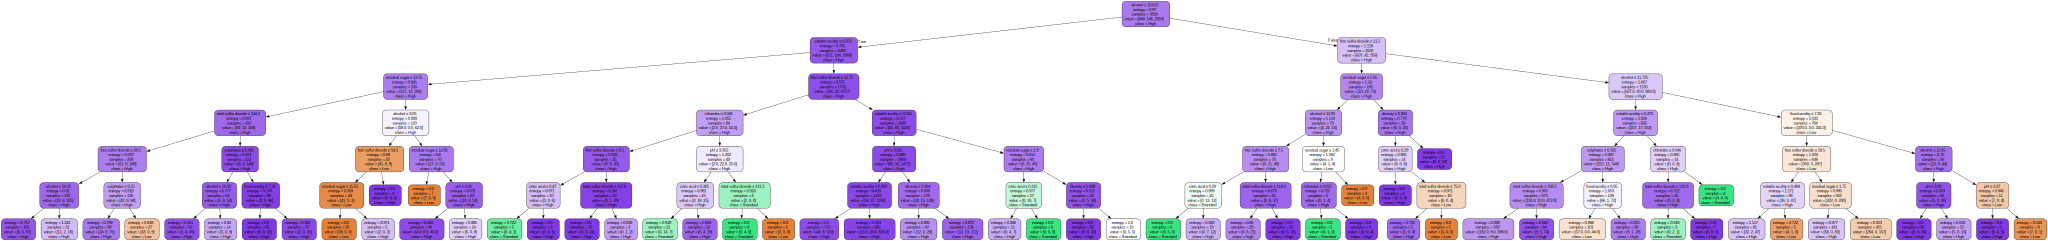

--- Decision Tree with max_depth=7 ---


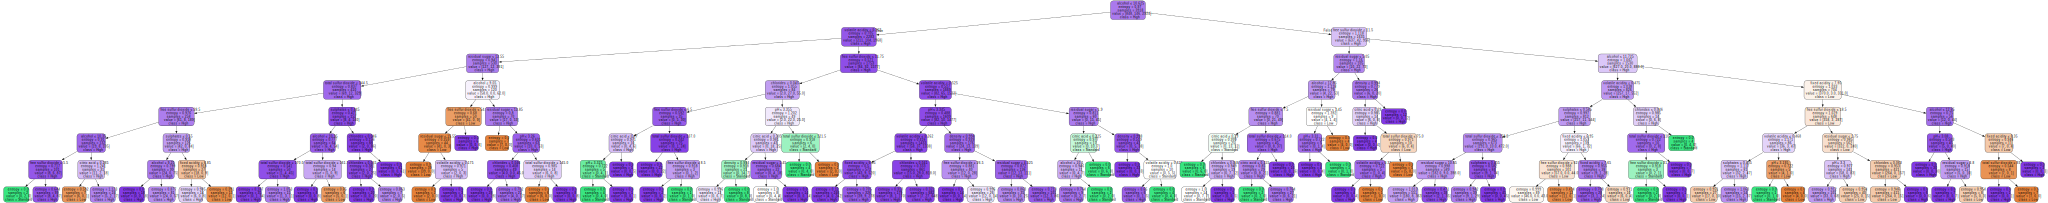

In [88]:
# 2. Thử nghiệm với các giá trị max_depth khác nhau
max_depth_values = [None, 2, 3, 4, 5, 6, 7]
accuracy_scores = {}

for max_depth in max_depth_values:
    # Tạo và huấn luyện cây quyết định với max_depth
    model = DecisionTreeClassifier(criterion='entropy', max_depth=max_depth, random_state=42)
    model.fit(X_train, y_train)
    
    # Dự đoán và tính độ chính xác
    predictions = model.predict(X_test)
    accuracy = accuracy_score(y_test, predictions)
    accuracy_scores[max_depth] = accuracy
    
    # Trực quan hóa cây quyết định
    print(f"--- Decision Tree with max_depth={max_depth} ---")
    dot_data = export_graphviz(
        model,
        out_file=None,
        feature_names=X_train.columns,
        class_names=['Low', 'Standard', 'High'],
        filled=True,
        rounded=True,
        special_characters=True
    )
    graph = graphviz.Source(dot_data)
    file_name = f"output2/tree_max_depth_{'None' if max_depth is None else max_depth}"
    graph.render(file_name)  # Lưu file PDF
    display(graph)


In [89]:
# 3. Hiển thị bảng kết quả
print("--- Accuracy Scores ---")
print("max_depth\tAccuracy")
for max_depth, accuracy in accuracy_scores.items():
    print(f"{'None' if max_depth is None else max_depth}\t\t{accuracy:.6f}")

--- Accuracy Scores ---
max_depth	Accuracy
None		0.782653
2		0.745918
3		0.764286
4		0.770408
5		0.771429
6		0.772449
7		0.777551


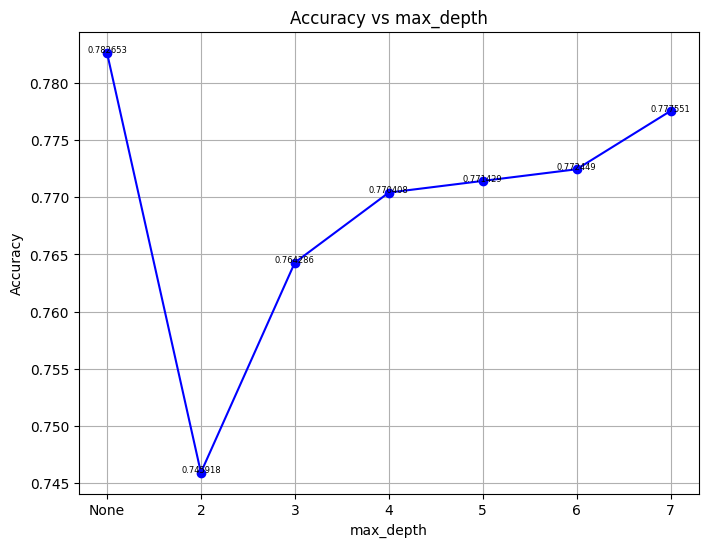

In [90]:
# 4. Vẽ biểu đồ độ chính xác
depth_labels = ['None' if d is None else d for d in max_depth_values]
accuracy_values = list(accuracy_scores.values())

plt.figure(figsize=(8, 6))
plt.plot(depth_labels, accuracy_values, marker='o', linestyle='-', color='b')
plt.title("Accuracy vs max_depth")
plt.xlabel("max_depth")
plt.ylabel("Accuracy")
plt.grid(True)
for i, txt in enumerate(accuracy_values):
    plt.text(i, accuracy_values[i], f"{accuracy_values[i]:.6f}", fontsize=6, ha='center')

plt.show()
